# What is behind auto-kerchunk?

Auto-kerchunk was developed in 2021, following [this blog post example of applying kerchunk to NetCDF4 datas stored in S3](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685), by adapting it to an HPC environment and automating the creation of a kerchunk catalog of many existing datasets in an HPC datalake.

This notebook explains what is behind auto-kerchunk by manually proceeding with the creation of a kerchunk catalog with recent update from the kerchunk capability 'auto_dask' .

For ODATIS data sets which are available in DATARMOR cluster and online access, in this example, we creates kerchunk catalogue in two format, 'HPC' and 'cloud'



auto-kerchunk was created to 
- convert multiple NetCDF files to kerchunk catalogue, 
- make an intake catalogue to be able to submit a job to PBS scheduler, 
- auto-mate that using bash script and submit that to PBS scheduler.  

Please refer to [this documentation](https://pangeo-data.github.io/clivar-2022/pangeo101/chunking_introduction.html) to understand what kerchunk is (as well as what zarr and 'chunk' mean).


## Starting Dask cluster on HPC

Please refer to the [Dask-hpcconfig datarmor example Jupyter notebook](https://github.com/umr-lops/dask-hpcconfig/tree/main/docs/tutorials) to understand what the next three cells mean.  

In [1]:
import dask_hpcconfig
from distributed import Client

In [2]:
overrides = {}  # ,"cluster.c": n_worker_per_node }

cluster = dask_hpcconfig.cluster("datarmor-local", **overrides)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60766,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:34741,Total threads: 7
Dashboard: http://127.0.0.1:48699/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:33149,


/home/datawork-lops-iaocea/conda-env/pangeo-fish_0623/lib/python3.11/site-packages/distributed/scheduler.py:5707: UserWarning: Scheduler already contains a plugin with name websocket; overwriting.
  warnings.warn(


## Converting Multiple NetCDF Files to a Kerchunk Catalogue

We use `kerchunk.combine.auto_dask`  with `kerchunk.hdf.SingleHdf5ToZarr`  

`kerchunk.combine.auto_dask`  convert each NetCDF files into kerchunk catalogue and concatenate them to one kerchunk catalogue all at once, in parallel using dask. 

## We will use [L3S Odyssea data](https://data.marine.copernicus.eu/product/SST_ATL_PHY_L3S_NRT_010_037/description) NetCDF4 datasets as an example.



First, we will list all the files we will use as 'file_pattern'.


In [5]:
import glob
levels=['l3s','l4']
zones=['/atl','/bra','/glob','/med'] #,'/gbr','/saf',,'/nwe'  only v2?
freqs=['nrt']# ,'rep','reprocessing']
#ATT rep does not have same folder structure , reprocessing, didn't check
versions=['/data/v3.0','/data/v2.0']

level=levels[0]
zone='/atl'
freq='/nrt'
version=versions[0]
year='/*'

# dir_url = 'https://data-dataref.ifremer.fr/marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/'
# file_pattern = 'MARC_F1-MARS3D-SEINE_*Z.nc'
#for zone in zones:
base_url='/home/ref-cersat-public/sea-surface-temperature/odyssea/'
dir_url=base_url+level+zone+freq+version+year


file_pattern = "/*/*.nc"
file_paths = glob.glob(dir_url + file_pattern)
print(file_paths[0], file_paths[-1])

/home/ref-cersat-public/sea-surface-temperature/odyssea/l3s/atl/nrt/data/v3.0/2021/175/20210624000000-IFR-L3S_GHRSST-SSTfnd-ODYSSEA-ATL_002-v02.1-fv01.0.nc /home/ref-cersat-public/sea-surface-temperature/odyssea/l3s/atl/nrt/data/v3.0/2020/365/20201230000000-IFR-L3S_GHRSST-SSTfnd-ODYSSEA-ATL_002-v02.1-fv01.0.nc


### Method 1

We use `kerchunk.hdf.SingleHdf5ToZarr` with `dask.bag` to convert each NetCDF file to kerchunk catalogs, and then concatenate them with `kerchunk.combine.MultiZarrToZarr` to create a single kerchunk catalog. This workflow is used in the first version of auto-kerchunk.


In [22]:
%%time
import dask.bag as db
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr


def translate_dask(file):
    url = "file://" + file
    #print("working on ", file)
    with fsspec.open(url) as inf:
        h5chunks = SingleHdf5ToZarr(inf, url, inline_threshold=100)
        return h5chunks.translate()


b = db.from_sequence(file_paths)
result_indask = b.map(translate_dask)
result = result_indask.compute()

from kerchunk.combine import MultiZarrToZarr

mzz = MultiZarrToZarr(
    result,
    concat_dims=["time"],
)
a = mzz.translate()

CPU times: user 4.67 s, sys: 556 ms, total: 5.23 s
Wall time: 35.4 s


## Loading data to Xarray using kerchunk and verify.

In [23]:
%%time
import xarray as xr

test = xr.open_dataset(
    "reference://",
    engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": a,
        },
        "consolidated": False,
    },
    chunks={},
)
test

CPU times: user 1.1 s, sys: 112 ms, total: 1.22 s
Wall time: 1.19 s


<xarray.Dataset>
Dimensions:                           (time: 946, lat: 2950, lon: 2000)
Coordinates:
  * lat                               (lat) float32 6.01 6.03 ... 64.97 64.99
  * lon                               (lon) float32 -23.99 -23.97 ... 15.99
  * time                              (time) datetime64[ns] 2020-12-16 ... 20...
Data variables:
    adjusted_sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_latitude                       (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_longitude                      (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_number_of_pixels               (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    quality_level                     (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    satellite_zenith_angle            (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sea_surface_temperature           (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    solar_zenith_angle                (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    source_of_sst                     (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sses_bias                         (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sses_standard_deviation           (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sst_dtime                         (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA North Ea...
    cmems_product_id:                SST_ATL_PHY_L3S_NRT_010_037
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2021-06-24T12:00:00
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-06-23T12:00:00
    title:                           ODYSSEA North-East Atlantic Sea Surface ...
    uuid:                            cab3c21e-a202-4ce5-acfb-c191532d4ea7

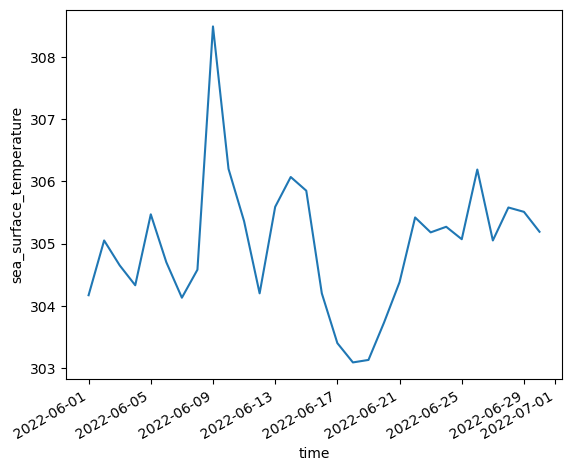

In [36]:
test.sea_surface_temperature.sel(time='2022-06').max(dim=['lat','lon']).plot()

## Publishing the kerchunk for the usage from HPC 


In [25]:
import os
#base_url='/home/ref-cersat-public/sea-surface-temperature/odyssea/'
base_url='/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/'

name=level+zone+freq+version

name=base_url+name.replace('/', '_')
#os.makedirs(name, exist_ok=True)
print(name)

/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l3s_atl_nrt_data_v3.0


In [26]:
import json
jsonfile=name+'.json.zstd'#+'IFR-L4_HRSST-SSTfnd-ODYSSEA-ATL_002-v02.1-fv01.0.json.zstd'
storage_options_in= {"compression": "zstd"}
with open(jsonfile, mode='w') as f :
    json.dump(a, f)

## Publishing the kerchunk for the usage from Cloud 


In [3]:
names=!find /home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/ |grep json.zst
names

['/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l3s_atl_nrt_data_v3.0.json.zstd',
 '/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l4_atl_nrt_data_v3.0.json.zstd']

In [7]:

import os
paths= [ os.path.dirname(name)   for name in names]
paths=list(set(paths))
def createpath(path):
    newpath=path.replace('intranet', 'public')
    return os.makedirs(newpath, exist_ok=True)
createpath= [ createpath(path)   for path in paths]

In [4]:
%%time
import xarray as xr
test= xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":'file://'+names[0],
        },
        "consolidated": False
    },chunks={}
)


CPU times: user 624 ms, sys: 144 ms, total: 768 ms
Wall time: 4.31 s


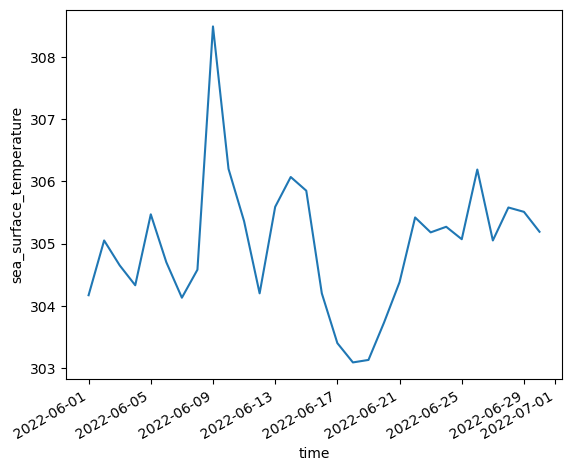

In [5]:
test.sea_surface_temperature.sel(time='2022-06').max(dim=['lat','lon']).plot()

## Translate kerchunk catalogue for intranet access to https access

In [33]:
import fsspec
import ujson
import dask



def match_keys(mapping, value):
    for k in mapping:
        if k in value: 
            return k
        
    raise ValueError(f"could not find {value} in mapping") 
    
def match_in_keys(mapping,value):
    try:
        match_keys(mapping,value)
        return True
    except ValueError:
        return False    

def rename_target(refs, renames):
    #from kerchunk.utils import conslidate
    print('in rename_target')
    """Utility to change URLs in a reference set in a predictable way

    For reference sets including templates, this is more easily done by
    using template overrides at access time; but rewriting the references
    and saving a new file means not having to do that every time.

    Parameters
    ----------
    refs: dict
        Reference set
    renames: dict[str, str]
        Mapping from the old URL (including protocol, if this is how they appear
        in the original) to new URL

    Returns
    -------
    dict: the altered reference set, which can be saved
    """
    fs = fsspec.filesystem("reference", fo=refs)  # to produce normalised refs
    refs = fs.references
    out = {}
    for k, v in refs.items():
        if isinstance(v, list) and v[0] in renames:
            out[k] = [renames[v[0]]] + v[1:]
        elif isinstance(v, list) and match_in_keys(renames, v[0]) :
            url = v[0]
            #print(url)
            key = match_keys(renames, url)
            new_url = url.replace(key, renames[key])
            out[k] = [new_url] + v[1:]
            #print(new_url)
        else:
            out[k] = v
        #    print('boo')
    return consolidate(out)

def rename_target_files(
    url_in, renames, url_out=None, storage_options_in=None, storage_options_out=None):
    #print('in rename_target_files',url_in,renames,url_out,storage_options_in, storage_options_out)

    """Perform URL renames on a reference set - read and write from JSON

    Parameters
    ----------
    url_in: str
        Original JSON reference set
    renames: dict
        URL renamings to perform (see ``renate_target``)
    url_out: str | None
        Where to write to. If None, overwrites original
    storage_options_in: dict | None
        passed to fsspec for opening url_in
    storage_options_out: dict | None
        passed to fsspec for opening url_out. If None, storage_options_in is used.

    Returns
    -------
    None
    """
    with fsspec.open(url_in, **(storage_options_in or {})) as f:
        print(url_in,storage_options_in)
        old = ujson.load(f)
    new = rename_target(old, renames)
    if url_out is None:
        url_out = url_in
    if storage_options_out is None:
        storage_options_out = storage_options_in
    with fsspec.open(url_out, mode="wt", **(storage_options_out or {})) as f:
        ujson.dump(new, f)

def consolidate(refs):
    """Turn raw references into output"""
    out = {}
    for k, v in refs.items():
        if isinstance(v, bytes):
            try:
                # easiest way to test if data is ascii
                out[k] = v.decode("ascii")
            except UnicodeDecodeError:
                out[k] = (b"base64:" + base64.b64encode(v)).decode()
        else:
            out[k] = v
    return {"version": 1, "refs": out}

#@dask.delayed
def translate(name):
    in_path='file:///home/ref-cersat-public/sea-surface-temperature/odyssea/'
    in_path='file:///home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/'
    out_path='file:///home/datawork-taos-s/public/kerchunk/ref-cersat-public/'
    name=name.replace('/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/','')
    url_in = in_path+name
    url_out = out_path+name

    renames={'file:///home/ref-cersat-public/':'https://data-cersat.ifremer.fr/data/'} 

    storage_options_in= {}#{"compression": "zstd"}
    storage_options_out= {"compression": "zstd"}
    return rename_target_files(
        url_in, renames, url_out, storage_options_in=storage_options_in
        , storage_options_out=storage_options_out ) 

In [34]:
translated= [ translate(name)   for name in names]

file:///home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l3s_atl_nrt_data_v3.0.json.zstd {}
in rename_target
file:///home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l4_atl_nrt_data_v3.0.json.zstd {}
in rename_target


In [10]:
names=!find /home/datawork-taos-s/*/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/ |grep json.zst
names

['/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l3s_atl_nrt_data_v3.0.json.zstd',
 '/home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l4_atl_nrt_data_v3.0.json.zstd',
 '/home/datawork-taos-s/public/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l3s_atl_nrt_data_v3.0.json.zstd',
 '/home/datawork-taos-s/public/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/l4_atl_nrt_data_v3.0.json.zstd']

In [14]:
!cat /home/datawork-taos-s/public/kerchunk/ref-cersat.yaml
!cat /home/datawork-taos-s/intranet/kerchunk/ref-cersat.yaml


name: cersat
sources:
  cersat:
    args:
      consolidated: false
      storage_options:
        fo: "https://data-taos.ifremer.fr/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/{{ level }}_{{ region }}_nrt_data_v3.0.json.zstd"
        target_options:
          compression: zstd
        target_protocol: https
      urlpath: reference://    
    description: "ref-cersat-public" 
    driver: zarr
    name: cersat
name: cersat
sources:
  cersat:
    args:
      consolidated: false
      storage_options:
        fo: "file:///home/datawork-taos-s/intranet/kerchunk/ref-cersat-public/sea-surface-temperature/odyssea/{{ level }}_{{ region }}_nrt_data_v3.0.json.zstd"
#        target_options:
#          compression: zstd
        target_protocol: file
      urlpath: reference://    
    description: "ref-cersat-public" 
    driver: zarr
    name: cersat


In [7]:
import fsspec
import intake
import xarray as xr


In [13]:
catalogue = "/home/datawork-taos-s/intranet/kerchunk/ref-cersat.yaml"
cat = intake.open_catalog(catalogue)
cat.cersat(region='atl' , level='l3s').to_dask()

<xarray.Dataset>
Dimensions:                           (time: 946, lat: 2950, lon: 2000)
Coordinates:
  * lat                               (lat) float32 6.01 6.03 ... 64.97 64.99
  * lon                               (lon) float32 -23.99 -23.97 ... 15.99
  * time                              (time) datetime64[ns] 2020-12-16 ... 20...
Data variables:
    adjusted_sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_latitude                       (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_longitude                      (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    or_number_of_pixels               (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    quality_level                     (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    satellite_zenith_angle            (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sea_surface_temperature           (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    solar_zenith_angle                (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    source_of_sst                     (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sses_bias                         (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sses_standard_deviation           (time, lat, lon) float32 dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
    sst_dtime                         (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 1475, 1000), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA North Ea...
    cmems_product_id:                SST_ATL_PHY_L3S_NRT_010_037
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2021-06-24T12:00:00
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-06-23T12:00:00
    title:                           ODYSSEA North-East Atlantic Sea Surface ...
    uuid:                            cab3c21e-a202-4ce5-acfb-c191532d4ea7